In [1]:
# Useful starting lines
%matplotlib inline
%load_ext autoreload
%autoreload 2
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from gensim import models
from collections import defaultdict

#Import all functions from the Labs and helpers
import utils
import text_cleaner
import features_analysis

#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

C:\Users\Leonovo\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Data loading

In [2]:
DATASET_PATH = '../twitter-datasets/'
SAMPLE = True

In [3]:
if SAMPLE:
    train_pos_data = utils.load_training_data(DATASET_PATH + "train_pos.txt")
    train_neg_data = utils.load_training_data(DATASET_PATH + "train_neg.txt")
else:
    train_pos_data = utils.load_training_data(DATASET_PATH +
                                              "train_pos_full.txt")
    train_neg_data = utils.load_training_data(DATASET_PATH +
                                              "train_neg_full.txt")

train_target = np.concatenate(
    (np.ones(len(train_pos_data)), (-np.ones(len(train_neg_data))))
)
train_data = np.concatenate((train_pos_data, train_neg_data))
test_data = utils.load_test_data("../twitter-datasets/test_data.txt")

Successfully loaded data from ../twitter-datasets/train_pos.txt
Successfully loaded data from ../twitter-datasets/train_neg.txt
Successfully loaded data from ../twitter-datasets/test_data.txt


In [4]:
train_data.shape

(200000,)

# Data preprocessing

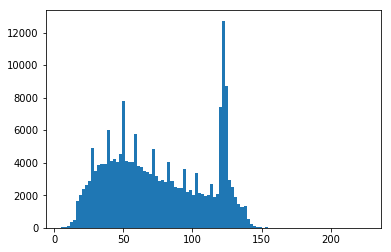

In [5]:
plt.hist([len(twit) for twit in train_data], bins=100)
plt.show()

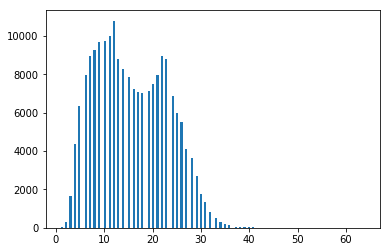

In [6]:
plt.hist([len(twit.split()) for twit in train_data], bins=140)
plt.show()

## custom data cleaning

In [7]:
cleaner = text_cleaner.text_cleaner()

In [8]:
train_data_cleaned = cleaner.apply_to_all(train_data)
test_data_cleaned = cleaner.apply_to_all(test_data)

100% (200000 of 200000) |#################| Elapsed Time: 0:01:40 Time: 0:01:40
100% (10000 of 10000) |###################| Elapsed Time: 0:00:05 Time: 0:00:05


In [9]:
train_data_cleaned_tokens = [nltk.word_tokenize(x) for x in train_data_cleaned]
test_data_cleaned_tokens = [nltk.word_tokenize(x) for x in test_data_cleaned]

# Text representation

## word2vec

In [12]:
bigram_transformer = models.Phrases(train_data_cleaned_tokens)
bigram_model = models.Word2Vec(bigram_transformer[train_data_cleaned_tokens], size=100, min_count=5, workers=4)
#model = models.Word2Vec(train_data_cleaned_tokens, size=100, window=5, min_count=5, workers=4)

C:\Users\Leonovo\Anaconda3\lib\site-packages\gensim\models\phrases.py:431: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [22]:
bigram_transformer.common_terms
bigram_transformer[train_data_cleaned_tokens]

C:\Users\Leonovo\Anaconda3\lib\site-packages\gensim\models\phrases.py:431: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [35]:
[print(x) for x in bigram_transformer[train_data_cleaned_tokens[1005:1010]]]

['<', 'user', '>', 'small', 'big_boob', 'blond', 'seek', 'danni', '(', 'the', 'script', ')', 'look_alik', 'lmao', 'xx']
['<', 'user', '>', 'lol', '!', 'and', 'when', 'we', 'decid', 'to', 'sing', 'somebodi', 'that', 'i', 'use', 'to', 'know', 'in', 'the', 'middl_of', 'adventur', 'island', 'like', 'cool', 'kid']
['peopl', 'gon_na', 'judg', 'im', 'sure', 'but', 'it', 'me', 'and', 'you', 'babe', '.']
['<', 'user', '>', 'i', 'wish', 'you', 'would', '!', 'lol', ',', 'then', 'i', 'could', 'return', 'the', 'favor', '!', ')']
['<', 'user', '>', 'challeng', 'accept', '!', '!', 'lol']


C:\Users\Leonovo\Anaconda3\lib\site-packages\gensim\models\phrases.py:431: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


[None, None, None, None, None]

In [37]:
# save model
#model.save('word2vecModel')
# load model
model = models.Word2Vec.load('word2vecModel') 

In [38]:
word_vector = model.wv
#del model

In [44]:
word_vector.similar_by_word('man',5)

[('girl', 0.6568259000778198),
 ('bitch', 0.6450958847999573),
 ('nigga', 0.5944597721099854),
 ('dude', 0.5779406428337097),
 ('kid', 0.5765169858932495)]

In [40]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = 100

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(lambda: max_idf,
                                       [(w, tfidf.idf_[i])
                                        for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
            np.mean(
                [
                    self.word2vec[w] * self.word2weight[w] for w in words
                    if w in self.word2vec
                ] or [np.zeros(self.dim)],
                axis=0) for words in X
        ])

In [41]:
w2v = dict(zip(word_vector.index2word, word_vector.syn0))
emb_vect = TfidfEmbeddingVectorizer(w2v).fit(train_data_cleaned, train_target)

In [42]:
train_data_cleaned_vect = emb_vect.transform(train_data_cleaned)
test_data_cleaned_vect = emb_vect.transform(test_data_cleaned)

### PCA kinda

In [126]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
svd.fit(train_data_tdidf)

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=42, tol=0.0)

In [127]:
train_data_cleaned_vect_reduced = svd.fit_transform(train_data_tdidf)

In [128]:
a = [0 if v is None else v for v in train_data_cleaned_vect_reduced]

In [129]:
a = np.array(a)
a.shape

(200000, 2)

[]

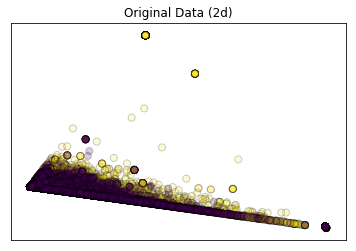

In [130]:
ax = plt.subplot()
ax.scatter(
    a[:, 0],
    a[:, 1],
    c=train_target,
    s=50,
    edgecolor='k',
    alpha=0.2)
ax.set_title("Original Data (2d)")
ax.set_xticks(())
ax.set_yticks(())

## tf idf

In [86]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_df=0.8)

In [87]:
train_data_tdidf = tfidf_vect.fit_transform(train_data_cleaned)
test_data_tdidf = tfidf_vect.transform(test_data_cleaned)
feat_names = tfidf_vect.get_feature_names()

In [27]:
len(feat_names)

5288384

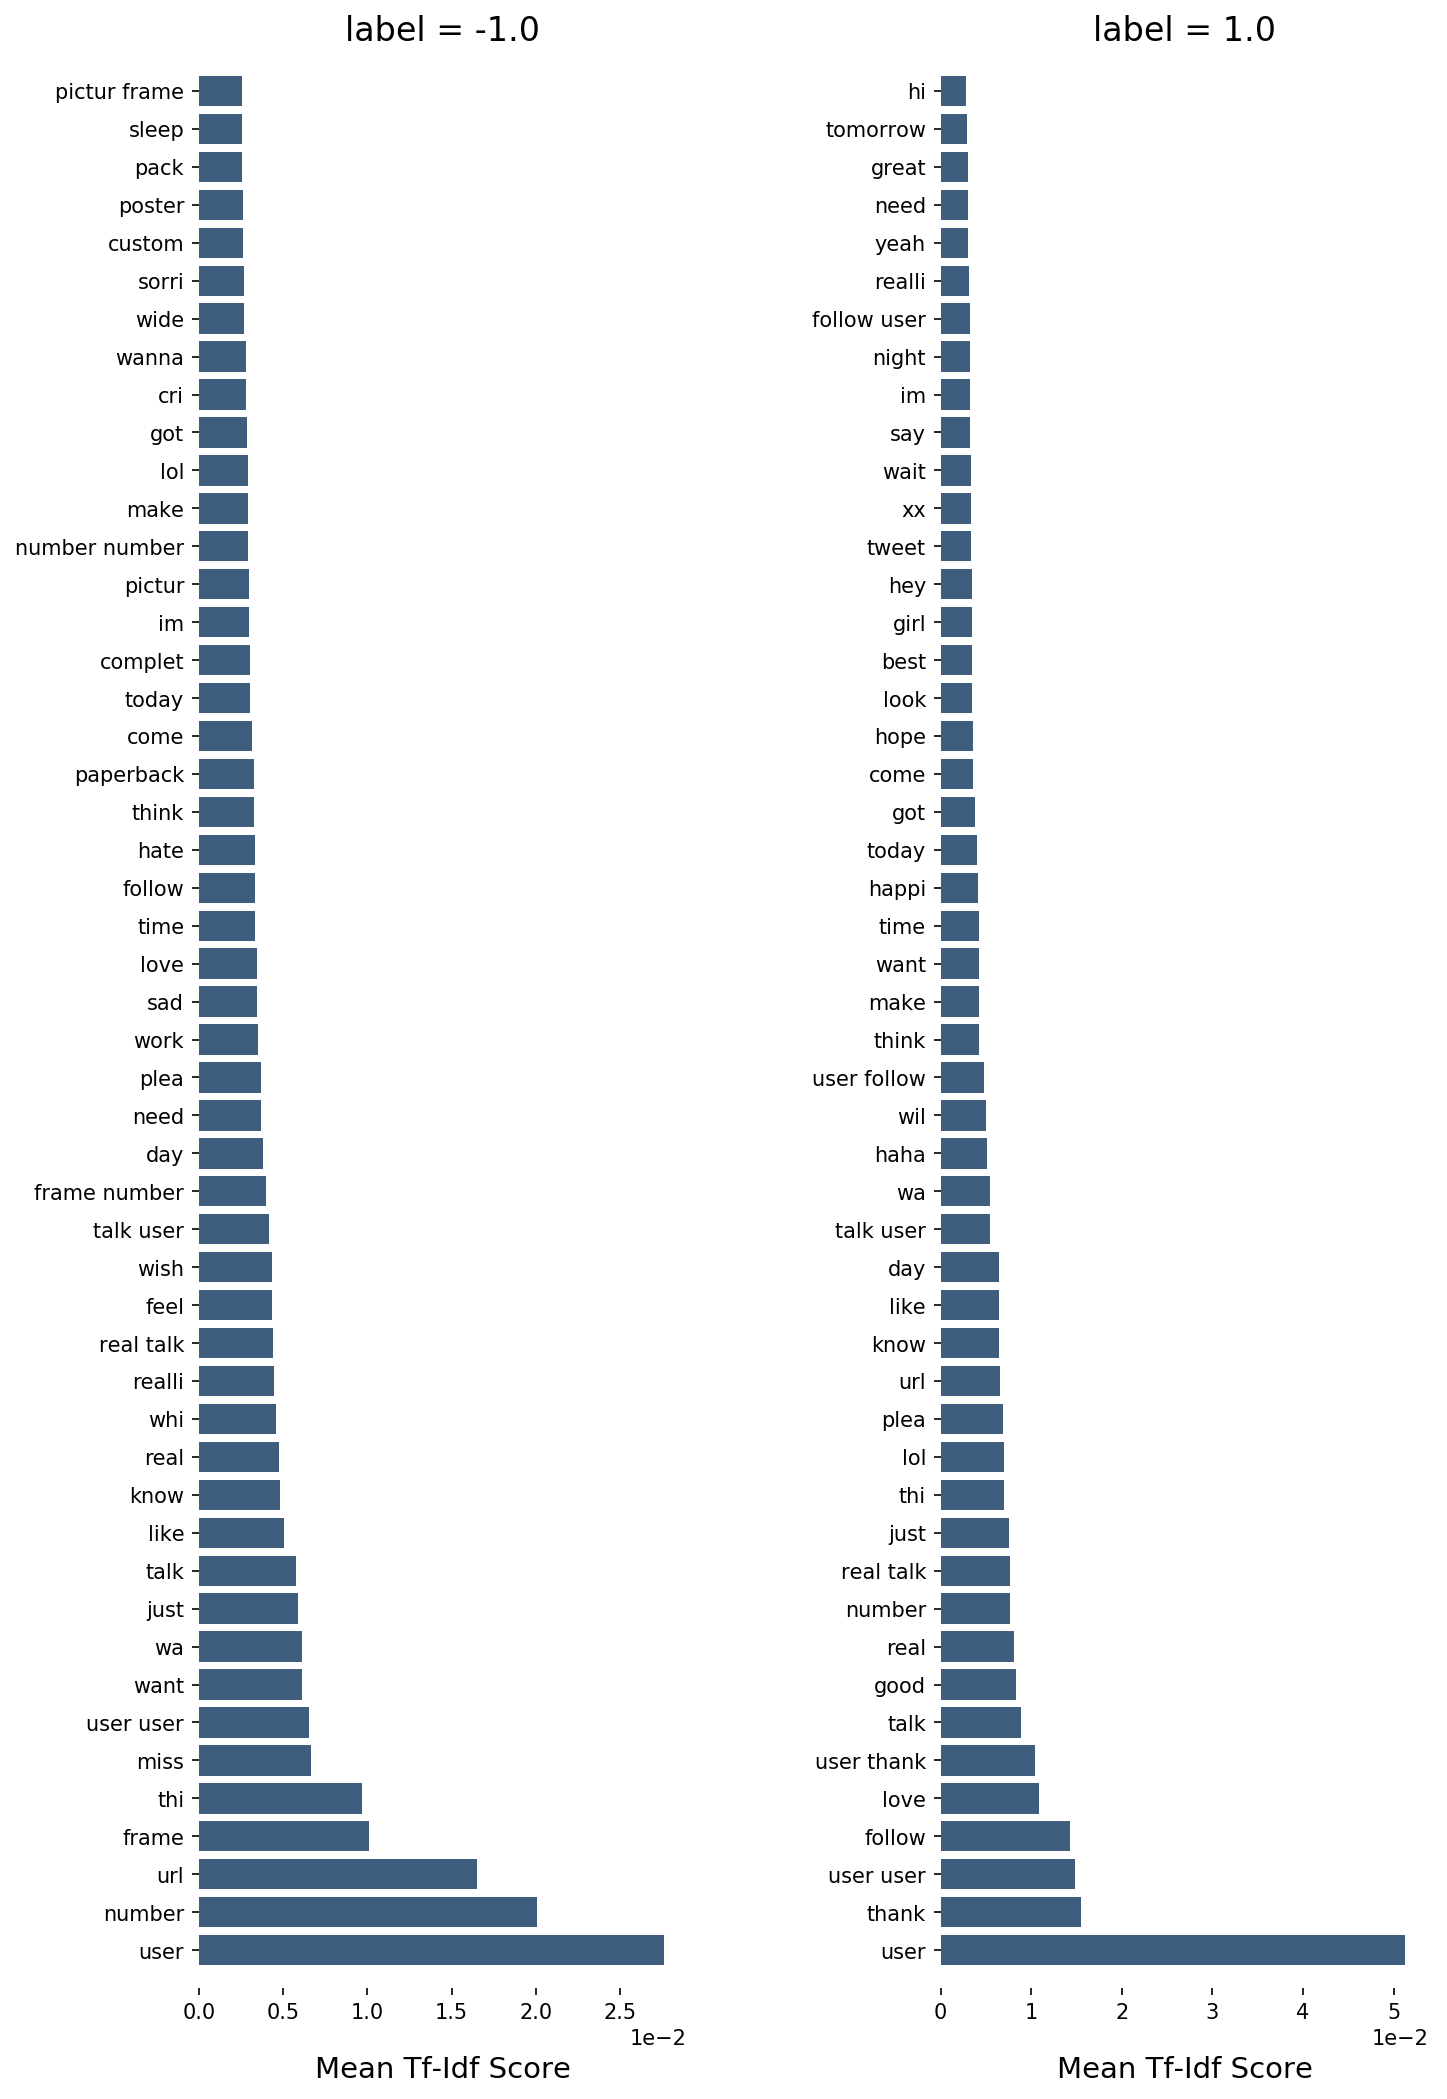

In [28]:
dfs = features_analysis.top_feats_by_class(train_data_tdidf, train_target, feat_names, top_n=50)
features_analysis.plot_tfidf_classfeats_h(dfs)

In [29]:
print(test_data_tdidf.shape)
print(train_data_tdidf.shape)

(10000, 5288384)
(2500000, 5288384)


# Machine learning

## Model selection

In [55]:
classifiers = [
    #MultinomialNB(),
    KNeighborsClassifier(),
    SGDClassifier(alpha=1e-5, random_state=42),
    SVC(gamma=2, C=1),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
]

classifiers_names = [
    #'naive Bayes',
    'KNN',
    'Linear classifiers (SVM, logistic regression) with SGD',
    'C-Support Vector Classification',
    'Random Forest'
]

def test_classifiers(classifiers, names, data, target, cv=3):
    for i, classifier in enumerate(classifiers):
        scores = cross_val_score(classifier, data, target, cv=cv, n_jobs=-1, verbose=10)
        print(names[i])
        print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

In [33]:
test_classifiers(classifiers, classifiers_names, train_data_tdidf, train_target)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.5s finished


naive Bayes
Accuracy: 0.797 (+/- 0.002)


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   33.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   33.8s finished


Linear classifiers (SVM, logistic regression) with SGD
Accuracy: 0.804 (+/- 0.001)
Random Forest
Accuracy: 0.500 (+/- 0.000)


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   48.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   48.0s finished


### with word2vec

In [70]:
train_data_cleaned_vect.shape


In [71]:
pupu = 3000
test_classifiers(classifiers, classifiers_names,
                 train_data_cleaned_vect[100000 - pupu:100000 + pupu],
                 train_target[100000 - pupu:100000 + pupu])

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished


KNN
Accuracy: 0.636 (+/- 0.010)


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished


Linear classifiers (SVM, logistic regression) with SGD
Accuracy: 0.638 (+/- 0.066)


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s finished


C-Support Vector Classification
Accuracy: 0.654 (+/- 0.021)
Random Forest
Accuracy: 0.613 (+/- 0.027)


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished


## Model tuning

In [10]:
text_clf = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_df=0.75)),
    ('clf', SGDClassifier(
        loss='hinge',
        penalty='l2',
        alpha=1e-5,
        random_state=42, )),
])

text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2), stop_words='english', max_df=0.75)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(
        loss='hinge',
        penalty='l2',
        alpha=1e-3,
        random_state=42, )),
])

parameters = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__ngram_range': ((1,1),(1, 2)),
    'clf__alpha': (1e-4, 1e-5, 1e-6),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__n_iter': (10, 50, 80),
}

parameters = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__ngram_range': ((1, 2)),
    #'loss' : ('hinge', 'log','squared_loss', 'huber', 'epsilon_insensitive'),
    'clf__alpha': np.logspace(-6, -9, 3),
    #'penalty': ('l2', 'elasticnet'),
    #'n_iter': (200),
    'clf__tol' : np.logspace(-3, -5, 3) ,
    'clf__max_iter' : (500,1000,2000)
}



gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, verbose=10, cv=3)

In [11]:
gs_clf = gs_clf.fit(train_data_cleaned, train_target)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 13.7min finished


In [12]:
gs_clf.best_score_

0.78688000000000002

In [13]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 3.1622776601683792e-06
clf__max_iter: 500
clf__tol: 0.001


## Validation

# Generate submission

In [38]:
clf = SGDClassifier(alpha=1e-6, n_iter=200, n_jobs=-1)
clf.fit(train_data_tdidf, train_target)
pred = clf.predict(test_data_tdidf)

In [39]:
utils.create_submission("submission", pred.astype(np.int64))

File submission.csv succesfully created with 10000 entries
